<a href="https://colab.research.google.com/github/Taedriel/ZSL-v2/blob/googleImageFSL/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install selenium
!pip install -U sklearn
!pip install scikit-learn-intelex
!pip install easyfsl
!pip install Pillow
!pip install pyod

!cd "./drive/MyDrive/Colab Notebooks/pipeline" && pip install -r requirements.txt

!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [ ]:
!sudo apt install python3-sklearn 

In [4]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, itertools, shutil, requests, webbrowser, urllib.request, time, random
import PIL.Image
from IPython.core.display import Image

from selenium import webdriver
from bs4 import BeautifulSoup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import utils
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from torch.autograd import Variable
import torch.nn.functional as F

from tqdm import tqdm
%matplotlib inline

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [ ]:
if not open("/content/drive/MyDrive/Colab Notebooks/pipeline/model/resnet18_with_pretraining.tar", "r"):
  os.system('wget https://public-sicara.s3.eu-central-1.amazonaws.com/easy-fsl/resnet18_with_pretraining.tar')

In [14]:
PATH = "/content/drive/MyDrive/Colab Notebooks/pipeline/"
PATH_IMAGES = "/content/drive/MyDrive/Colab Notebooks/pipeline/images/"
PATH_MODEL = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/"

globalSize = 20
LEN_FOR_ONE_SCROLL = 20
retreivalNotDone = False
trainingNeeded = False

In [ ]:
def createClasses(classesFile):

  classes = ""
  classesTr = []
  classesTe = []
  classeForSimilarity = []
  index=0

  for animal in classesFile.readlines():

    animal = animal.strip("\n").replace(" ", "")
    if animal!="list":
      classes+=animal+", "

      if index%2:
        classesTe.append(animal)
      else:
        classesTr.append(animal)
      index+=1

  ridx = random.randint(0, len(classesTe)-1)
  classeForSimilarity.append(classesTe[ridx])
  classesTe.remove(classeForSimilarity[0])

  print("training / testing :", classesTr[0:5])

  return classes, classesTr[0:5], classesTe, classeForSimilarity

In [ ]:
classesFile = open(PATH_MODEL+"animals.txt")
classes, classesTr, _, i = createClasses(classesFile)

training / testing : ['Aardvark', 'Africanbuffalo', 'Africanleopard', 'Alligator', 'Americanrobin']


--- IMAGE RETRIEVAL ---

In [ ]:
"""
thumbnail / jpg (compression) may be an issue
"""

def getParser(classeName):

  site = 'https://www.google.com/search?tbm=isch&q='+classeName

  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')

  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  driver.get(site)
  driver.execute_script("window.scrollBy(0, document.body.scrollHeight)")
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  driver.close()

  return soup


def getClassesImagesURLLIB():

  imagesNumber = 0

  shutil.rmtree(PATH_IMAGES, ignore_errors=False)
  os.makedirs(PATH_IMAGES)

  for classe in classes.split(","):

    try:
      classeName = classe.replace(" ", "")
      os.makedirs(PATH_IMAGES+classeName)

      soup = getParser(classeName)
      img_tags = soup.find_all("img", class_="rg_i")
      for index in range(0, len(img_tags)):
        try:
            urllib.request.urlretrieve(img_tags[index]['src'], PATH_IMAGES+classeName+"/"+str(classeName+str(index))+".jpg")
            imagesNumber+=1
        except Exception as e:
            pass
    except:
      pass

  print(str(imagesNumber) + " images were downloaded. " + str(imagesNumber/len(classes.split(","))) + " per classes")

In [ ]:
if retreivalNotDone:
  getClassesImagesURLLIB()
  retreivalNotDone = False

--- DATASETS ---

In [ ]:
image_size = 28

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = Omniglot(
    root="/content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=False,
)
test_set = Omniglot(
    root="/content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=False,
)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO/omniglot-py/images_background.zip to /content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO/omniglot-py/images_evaluation.zip to /content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO/omniglot-py


In [ ]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


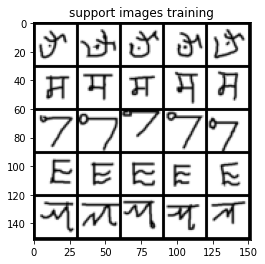

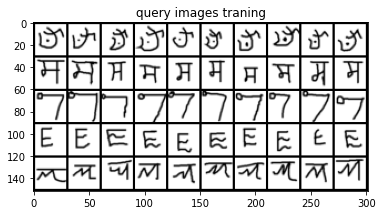

In [ ]:
(example_support_images,
example_support_labels,
example_query_images,
example_query_labels,
example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images training", images_per_row=N_SHOT)
plot_images(example_query_images, "query images traning", images_per_row=N_QUERY)

In [16]:
%cd "/content/drive/MyDrive/Colab Notebooks/pipeline/model/"

/content/drive/MyDrive/Colab Notebooks/pipeline/model


In [157]:
from easyfsl.datasets import CUB

N_WAY = 5  # Number of classes in a task
N_SHOT = 20  # Number of images per class in the support set
N_QUERY = 1  # Number of images per class in the query set
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100
N_EVALUATION_TASKS = 100

train_set = CUB(split="train", training=True)
test_set = CUB(split="test", training=False)

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


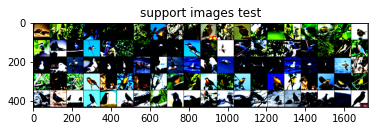

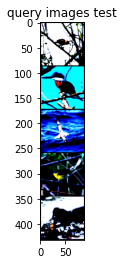

In [158]:
(example_support_images,
example_support_labels,
example_query_images,
example_query_labels,
example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images test", images_per_row=N_SHOT)
plot_images(example_query_images, "query images test", images_per_row=N_QUERY)

--- PROTOTYPICAL NETWORK ---

In [19]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor,) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        dists = torch.cdist(z_query, z_proto)
        scores = -dists
        #print("d(query, prototype) = ", dists)
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network) #.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# those two followings are the meta training

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor,) -> float:
    optimizer.zero_grad()
    classification_scores = model(support_images, support_labels, query_images)
    #support_images.cuda(), support_labels.cuda(), query_images.cuda()

    loss = criterion(classification_scores, query_labels) #query_labels.cuda()
    loss.backward()
    optimizer.step()

    return loss.item()

def trainOnSet(datasetL):
  log_update_frequency = 10
  all_loss = []
  model.train()

  # training here, tqdm is for the progress bar
  with tqdm(enumerate(datasetL), total=len(datasetL)) as tqdm_train:
      for episode_index, (support_images, support_labels, query_images, query_labels, _,) in tqdm_train:
          loss_value = fit(support_images, support_labels, query_images, query_labels)
          all_loss.append(loss_value)

          if episode_index % log_update_frequency == 0:
              tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  torch.save(model.state_dict(), PATH_MODEL+"proto_model.pt")

In [150]:
def getCUBClassesForATask(label_ids, classNames):
  carac = [""]*N_WAY
  previousLen = 0

  for i in range(0, N_WAY):

    labelI = label_ids[i*N_SHOT]
    name = classNames[labelI]
    firstName, lastName = name.split(".")[1].split("/")[-1].split("_")[0:2]
    carac[labelI] = firstName[0:2]+lastName[0:2]
    
  return carac

classesList = lambda i, ids, classesNames: getCUBClassesForATask(ids, classesNames)[i]

def printConfusionMatrix(confM, label_ids, classNames):

  print("\n")
  print("A/P \t", end="")

  for i in range(0, len(confM)):
    print(classesList(i, label_ids, classNames) + "\t", end="")

  print("\n")
  for i in range(0, len(confM)):
    print(classesList(i, label_ids, classNames) + "\t", end="")
    for j in range(0, len(confM[0])):
      print(str(confM[i][j]) + "\t", end="")
    print("\n")

In [162]:
#suppr les cuda sur examples
#prediction on one support

if trainingNeeded:
  trainOnSet(train_loader)

model.eval()
example_scores = model(
    example_support_images,
    example_support_labels,
    example_query_images,
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)
classNames = test_set.class_names

confM = [
         [0 for i in range(0, N_WAY)] for j in range (0, N_WAY)
        ]
accuracy = 0

print(example_support_images)

for i in range(len(example_query_labels)):
  print(f"{classNames[example_query_labels[i]]} / {classNames[example_predicted_labels[i]]}")
  if classNames[example_query_labels[i]] == classNames[example_predicted_labels[i]]:
    accuracy+=1
  
  k = example_query_labels[i]
  l = example_predicted_labels[i]
  confM[k][l]+=1

printConfusionMatrix(confM, example_support_labels, classNames)
print("accuracy for this task : ", accuracy/len(example_query_labels)*100, "%")

tensor([[[[-0.2342, -0.1314,  0.1597,  ..., -0.1486, -0.0629,  0.1768],
          [-0.2342, -0.0116,  0.3138,  ..., -0.1143,  0.0056,  0.2282],
          [-0.2171, -0.0116,  0.2624,  ..., -0.0801,  0.0912,  0.2624],
          ...,
          [-1.5870, -1.5185, -1.4500,  ..., -0.4226, -0.2171, -0.3027],
          [-1.6213, -1.5528, -1.5185,  ..., -0.4397, -0.3198, -0.2856],
          [-1.6555, -1.5870, -1.5357,  ..., -0.3369, -0.3712, -0.3369]],

         [[-0.5126, -0.3725, -0.0049,  ..., -0.4076, -0.3200, -0.0574],
          [-0.5126, -0.2500,  0.1702,  ..., -0.3901, -0.2500, -0.0049],
          [-0.4776, -0.2500,  0.1001,  ..., -0.3200, -0.1450,  0.0301],
          ...,
          [-1.8081, -1.7556, -1.7206,  ..., -0.7402, -0.5126, -0.5826],
          [-1.8256, -1.7731, -1.7381,  ..., -0.7402, -0.6352, -0.5826],
          [-1.8431, -1.8081, -1.7556,  ..., -0.5826, -0.6527, -0.6176]],

         [[-0.9504, -0.7761, -0.2881,  ..., -0.7936, -0.7238, -0.4624],
          [-0.9678, -0.6367, -

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/pipeline/model/resnet18_with_pretraining.tar", map_location="cpu"))

In [160]:
cuda = False

def createConfusionMatrix(model, confusionMatrix):

  example_scores = model(
    example_support_images,
    example_support_labels,
    example_query_images,
    ).detach()

  _, example_predicted_labels = torch.max(example_scores.data, 1)

  for i in range(len(example_query_labels)):
    
    k = example_query_labels[i]
    l = example_predicted_labels[i]
    confusionMatrix[k][l]+=1

  return confusionMatrix

def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor,confusionMatrixI_1,) -> [int, int]:
  
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """

    confusionMatrixI = createConfusionMatrix(model, confusionMatrixI_1)
    
    if cuda:

      return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1] == query_labels.cuda()).sum().item(), len(query_labels), confusionMatrixI

    else:

      return (
        torch.max(
            model(support_images, support_labels, query_images)
            .detach()
            .data,
            1,
        )[1] == query_labels).sum().item(), len(query_labels), confusionMatrixI


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0
    confusionMatrix = np.array([
            [0 for i in range(0, N_WAY)] for j in range (0, N_WAY)
            ])
    classNames = test_set.class_names

    
    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total, confusionMatrix = evaluate_on_one_task(support_images, support_labels, query_images, query_labels, confusionMatrix)

            total_predictions += total
            correct_predictions += correct

    printConfusionMatrix(confusionMatrix, support_labels, classNames)
    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

In [161]:
evaluate(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [05:12<00:00,  3.13s/it]



A/P 	RhAu	BrBl	LaBu	Yebr	BrCr	

RhAu	0	0	0	0	100	

BrBl	0	100	0	0	0	

LaBu	0	0	100	0	0	

Yebr	0	0	0	100	0	

BrCr	0	0	0	0	100	

Model tested on 100 tasks. Accuracy: 73.00%
